# Group 1 — NLP Fake News Classification  

**Ironhack NLP Challenge** 

**By**:  Ben, Bianca, Quincy and Armando.

**Expected repo structure**
```
repo/
  data/
    training_data_lowercase.csv
    testing_data_lowercase_nolabels.csv
  code/
    model1.ipynb   (was main)
    model2.ipynb  (etc)
```

---

## Presentation alignment (quick)
Use this notebook to produce the artifacts you need for the slides:
- Executive summary (best model + metrics)
- Methods: preprocessing, embedding (optional), models
- Training vs Validation comparison
- Takeaways / learnings


## 1) Setup (imports + reproducibility)
Keep imports centralized and keep a fixed random seed so results are comparable across team members.


In [1]:
import re
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


> **Summary**  
> - Notes here


## 2) Paths + configurations
This avoids common path issues when the notebook runs from `/code`.


In [2]:
# Robust: locate the repo root by walking upward until we find a /data folder
HERE = Path(__file__).parent if "__file__" in globals() else Path.cwd()

PROJECT_ROOT = None
for p in [HERE] + list(HERE.parents):
    if (p / "data").exists():
        PROJECT_ROOT = p
        break

assert PROJECT_ROOT is not None, "Could not find repo root (a folder containing /data)."

DATA_DIR = PROJECT_ROOT / "data"

TRAIN_FILE = DATA_DIR / "training_data_lowercase.csv"
TEST_FILE  = DATA_DIR / "testing_data_lowercase_nolabels.csv"

assert TRAIN_FILE.exists(), f"Missing: {TRAIN_FILE.resolve()}"
assert TEST_FILE.exists(),  f"Missing: {TEST_FILE.resolve()}"

print("✓ Files found:", TRAIN_FILE.name, "and", TEST_FILE.name)
print("PROJECT_ROOT:", PROJECT_ROOT)


✓ Files found: training_data_lowercase.csv and testing_data_lowercase_nolabels.csv
PROJECT_ROOT: C:\Users\Ben_h\Ironhack\Ironhack-week4\project-nlp-challenge-group1


> **Comments:**  
> - notes


## 3) Load data + Quick checks
To confirm:
- columns are what we expect
- missing values are manageable
- label distribution (class balance)


In [3]:
train_df = pd.read_csv(TRAIN_FILE)
test_df  = pd.read_csv(TEST_FILE)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

print("\nTrain columns:", list(train_df.columns))
print("Test columns :", list(test_df.columns))

train_df.head()


Train shape: (34151, 1)
Test shape : (9983, 1)

Train columns: ['0\tdonald trump sends out embarrassing new year‚s eve message; this is disturbing']
Test columns : ['2\tcopycat muslim terrorist arrested with assault weapons']


,0\tdonald trump sends out embarrassing new year‚s eve message; this is disturbing
0,0\tdrunk bragging trump staffer started russia...
1,0\tsheriff david clarke becomes an internet jo...
2,0\ttrump is so obsessed he even has obama‚s na...
3,0\tpope francis just called out donald trump d...
4,0\tracist alabama cops brutalize black boy whi...


In [4]:
# ---- Basic missing-value checks (top 10 columns by NA rate) ----
display(train_df.isna().mean().sort_values(ascending=False).head(10))
display(test_df.isna().mean().sort_values(ascending=False).head(10))


0\tdonald trump sends out embarrassing new year‚s eve message; this is disturbing    0.0
dtype: float64

2\tcopycat muslim terrorist arrested with assault weapons    0.0
dtype: float64

### Set the column names



In [9]:
import pandas as pd
from pathlib import Path

# Setup paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
TRAIN_FILE = DATA_DIR / "training_data_lowercase.csv"
TEST_FILE = DATA_DIR / "testing_data_lowercase_nolabels.csv"

# Load data with correct delimiter (tab-separated)
train_df = pd.read_csv(TRAIN_FILE, sep='\t', header=None, names=['label', 'text'])
test_df = pd.read_csv(TEST_FILE, sep='\t', header=None, names=['label', 'text'])

# Now define your column references
TEXT_COL  = "text"
LABEL_COL = "label"

# Assertions should now pass
assert TEXT_COL in train_df.columns, f"TEXT_COL='{TEXT_COL}' not found."
assert TEXT_COL in test_df.columns, f"TEXT_COL='{TEXT_COL}' not found in test."
assert LABEL_COL in train_df.columns, f"LABEL_COL='{LABEL_COL}' not found."
assert LABEL_COL in test_df.columns, f"LABEL_COL='{LABEL_COL}' not found in test."

print("✓ All assertions passed!")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTrain columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")

# Label distribution
display(train_df[LABEL_COL].value_counts(dropna=False))


✓ All assertions passed!
Train shape: (34152, 2)
Test shape: (9984, 2)

Train columns: ['label', 'text']
Test columns: ['label', 'text']


label
0    17572
1    16580
Name: count, dtype: int64

> **Comments:**  
> - comments here


## 4) Preprocessing
- Remove leading/trailing whitespace
- Remove punctuation,
- ***Adjust and tweak as needed


In [6]:
def clean_text(text: str) -> str:
    text = str(text)

    # Keep letters + whitespace (remove punctuation, digits, symbols)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    # Remove standalone single letters
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)

    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    # Lowercase
    return text.lower()


In [10]:
# Apply NA handling + cleaning to the text columns
train_df[TEXT_COL] = train_df[TEXT_COL].fillna("").map(clean_text)
test_df[TEXT_COL]  = test_df[TEXT_COL].fillna("").map(clean_text)

# Target (optional label cleanup)
train_df[LABEL_COL] = train_df[LABEL_COL].astype(str).str.strip()

train_df[[TEXT_COL, LABEL_COL]].head() # Check data


,text,label
0,donald trump sends out embarrassing new year e...,0
1,drunk bragging trump staffer started russian c...,0
2,sheriff david clarke becomes an internet joke ...,0
3,trump is so obsessed he even has obama name co...,0
4,pope francis just called out donald trump duri...,0


> **Comments:**  
> - notes


## 5) Train/Validation split
We split once for fast iteration and fair model comparison.


In [11]:
X = train_df[TEXT_COL]
y = train_df[LABEL_COL]
X_test = test_df[TEXT_COL]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (27321,) Val: (6831,)


## 6) Model 1
Model 1(base model): TF‑IDF + Logistic Regression is a strong, explainable baseline for text classification.


In [16]:
Model1 = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ("clf", LogisticRegression(max_iter=2000))
])

t0 = time.perf_counter()
Model1.fit(X_train, y_train)
fit_s = time.perf_counter() - t0

y_pred = Model1.predict(X_val)

print("Model 1: TFIDF + LogisticRegression")
print("Fit seconds:", round(fit_s, 3))
print("Accuracy:", round(accuracy_score(y_val, y_pred), 4))
print("F1 (weighted):", round(f1_score(y_val, y_pred, average="weighted"), 4))


Model 1: TFIDF + LogisticRegression
Fit seconds: 0.51
Accuracy: 0.9454
F1 (weighted): 0.9454


In [ ]:
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot()
plt.show()


> **Comments:**  
> - notes..


## 7) Multi‑model comparison
Compare your own model against other models you made or was made in your team.

 In this example a small set of classic NLP models with the same evaluation routine (GPT).


In [17]:
def eval_model(pipe: Pipeline, name: str):
    t0 = time.perf_counter()
    pipe.fit(X_train, y_train)
    fit_s = time.perf_counter() - t0

    pred = pipe.predict(X_val)

    return {
        "model": name,
        "fit_seconds": round(fit_s, 3),
        "accuracy": accuracy_score(y_val, pred),
        "f1_weighted": f1_score(y_val, pred, average="weighted"),
        "precision_weighted": precision_score(y_val, pred, average="weighted", zero_division=0),
        "recall_weighted": recall_score(y_val, pred, average="weighted", zero_division=0),
    }, pred


In [18]:

candidates = {
    "TFIDF + LogisticRegression": Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
        ("clf", LogisticRegression(max_iter=2000))
    ]),
    "TFIDF + LinearSVC": Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
        ("clf", LinearSVC())
    ]),
    "Count + MultinomialNB": Pipeline([
        ("count", CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
        ("clf", MultinomialNB())
    ]),
}

rows = []
preds = {}

for name, pipe in candidates.items():
    row, pred = eval_model(pipe, name)
    rows.append(row)
    preds[name] = pred

results_df = pd.DataFrame(rows).sort_values("f1_weighted", ascending=False)
results_df


,model,fit_seconds,accuracy,f1_weighted,precision_weighted,recall_weighted
1,TFIDF + LinearSVC,0.441,0.953887,0.953890,0.953912,0.953887
2,Count + MultinomialNB,0.415,0.946128,0.946116,0.946176,0.946128
0,TFIDF + LogisticRegression,0.627,0.945396,0.945405,0.945511,0.945396


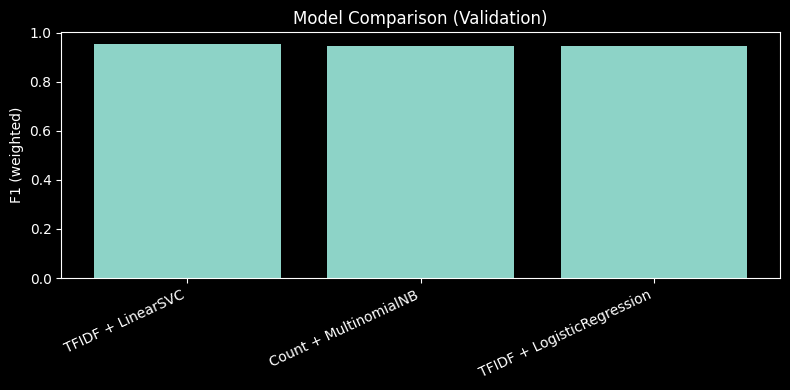

In [20]:
# Simple bar chart example for presentation (F1)
plt.figure(figsize=(8,4))
plt.bar(results_df["model"], results_df["f1_weighted"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("F1 (weighted)")
plt.title("Model Comparison (Validation)")
plt.tight_layout()
plt.show()


> **Comments:**  
> - notes. 


## 8) Other Algorithms:  Random Forest (non‑NLP baseline)
Random Forest can work, but text vectors are high‑dimensional; keep features limited.
If this doesn’t improve results, exclude it from the slides to keep them clean.


In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, max_features=20000)),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf_row, rf_pred = eval_model(rf_pipe, "TFIDF (max_features=20k) + RandomForest")
pd.DataFrame([rf_row])


,model,fit_seconds,accuracy,f1_weighted,precision_weighted,recall_weighted
0,TFIDF (max_features=20k) + RandomForest,6.289,0.931196,0.931211,0.931578,0.931196


> **Comments:**  
> - notes..


## 9) Optional Models: Simple Neural Network + (embeddings)
This is a compact NN baseline using:
- TextVectorization → integer tokens
- Embedding → dense representation
- GlobalAveragePooling → sentence-level vector
- Dense output

Only include if your group wants a “deep learning” comparison.

NOTE: ** You may need google colab **

In [23]:
# If TensorFlow isn't installed in your environment, skip this section.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


ModuleNotFoundError: No module named 'tensorflow'

In [24]:
# Prepare text vectorizer
max_tokens = 20000
seq_len = 250

vectorize = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=seq_len
)

# Adapt on training texts only
vectorize.adapt(X_train.values)

# Build model
num_classes = y.nunique()
classes = sorted(y.unique())
class_to_index = {c:i for i,c in enumerate(classes)}
y_train_int = y_train.map(class_to_index).values
y_val_int   = y_val.map(class_to_index).values

nn_model = keras.Sequential([
    keras.Input(shape=(1,), dtype=tf.string),
    vectorize,
    layers.Embedding(max_tokens, 64),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

nn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

nn_model.summary()


NameError: name 'layers' is not defined

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

t0 = time.perf_counter()
history = nn_model.fit(
    X_train.values,
    y_train_int,
    validation_data=(X_val.values, y_val_int),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)
fit_s = time.perf_counter() - t0
print("NN fit seconds:", round(fit_s, 2))


In [ ]:
# Evaluate NN on validation
val_prob = nn_model.predict(X_val.values, verbose=0)
val_pred_int = val_prob.argmax(axis=1)
val_pred = pd.Series(val_pred_int).map({v:k for k,v in class_to_index.items()})

print("NN Accuracy:", round(accuracy_score(y_val, val_pred), 4))
print("NN F1 (weighted):", round(f1_score(y_val, val_pred, average="weighted"), 4))


> **Comments:**  
> - comments here...


## 10)  “Best” model + train on full training set
Pick the best model based on **validation F1** (or your agreed metric).


In [ ]:
# Choose best from the classic comparison table by default
best_name = results_df.iloc[0]["model"]
best_pipe = candidates[best_name]

print("Best classic model:", best_name)

best_pipe.fit(X, y)
test_pred = best_pipe.predict(X_test)

pd.Series(test_pred).value_counts().head(10)


## 11) Export model results CSV
Keep this consistent for submission + GitHub.


In [ ]:
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(exist_ok=True)

pred_path = OUT_DIR / "predictions.csv"

# If your test file has an ID column, set it here. Otherwise we use row index.
ID_COL = "id" if "id" in test_df.columns else None

if ID_COL is not None:
    out_df = pd.DataFrame({ID_COL: test_df[ID_COL], LABEL_COL: test_pred})
else:
    out_df = pd.DataFrame({"id": np.arange(len(test_df)), LABEL_COL: test_pred})

out_df.to_csv(pred_path, index=False)
print("✓ Saved:", pred_path.resolve())
out_df.head()


> **Comments:**  
> - comments.. 


## 12) Final takeaways (for this model) 
Great for PPT preperation later


In [ ]:
# Example structure / or just use the comment box below

takeaways = [
    "Best performing model: ________ (why it worked).",
    "Most useful preprocessing: ________ (or minimal cleaning was enough).",
    "Key metric used: F1 weighted (balanced evaluation).",
    "Main challenges: e.g., ambiguous headlines, short texts, class overlap.",
    "What we'd try next: e.g., better n-grams, stopwords, lemmatization, transformer baseline (if allowed)."
]

for t in takeaways:
    print("-", t)


> **Final take aways from this model**  
> - comments.. 


## 13) Save Model

In [27]:
from pathlib import Path
import joblib
# Name your model here and run to save.
best_pipe = Model1

# Use PROJECT_ROOT (already defined in your notebook)
MODELS_DIR = PROJECT_ROOT / "Models"
MODELS_DIR.mkdir(exist_ok=True)

# Define model path clearly
model_path = MODELS_DIR / "tfidf_logreg.joblib"

# Save the model
joblib.dump(best_pipe, model_path)

print("✓ Model saved to:", model_path.resolve())

✓ Model saved to: C:\Users\Ben_h\Ironhack\Ironhack-week4\project-nlp-challenge-group1\models\tfidf_logreg.joblib
